# Chapter 5. The Many Variables & The Spurious Waffles

In [1]:
import math
import os

import arviz as az
import daft
import matplotlib.pyplot as plt
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

### Code 5.1

In [2]:
# load data and copy
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

### Code 5.2

In [3]:
d

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D,M
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000,-0.606290,1.654205,0.022644
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000,-0.686699,1.544364,1.549802
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000,-0.204241,0.610716,0.048974
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000,-1.410387,2.093569,1.655123
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000,0.599857,-0.927058,-0.266989
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000,-0.284651,1.050080,0.891544
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000,1.243135,-1.641024,-0.793595
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000,0.439037,-0.432773,0.786223
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000,2.931739,-1.860706,-0.635614
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000,0.278218,-0.652455,-0.819926


In [4]:
d.MedianAgeMarriage.std()

1.2436303013880823

### Code 5.3

In [5]:
def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_1 = AutoLaplaceApproximation(model)

### Code 5.4

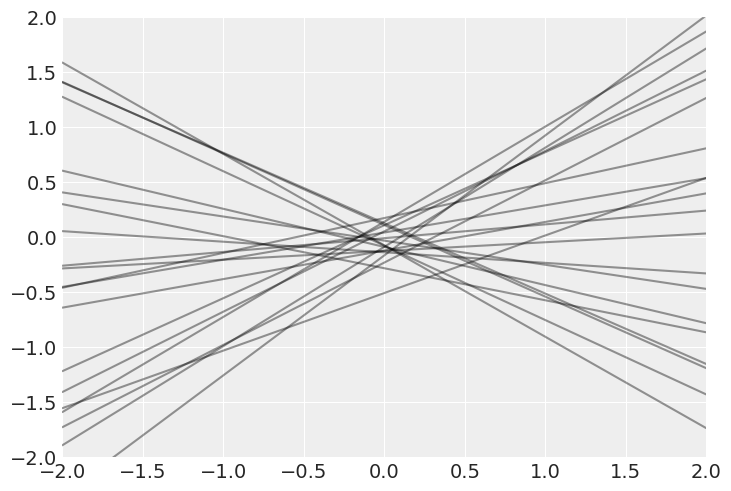

In [6]:
# Predictive prior
predictive = Predictive(m5_1.model, num_samples=1000, return_sites=["mu"])
prior_pred = predictive(random.PRNGKey(10), A=jnp.array([-2, 2]))
mu = prior_pred["mu"]
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)

### Code 5.5

100%|██████████| 1000/1000 [00:01<00:00, 828.54it/s, init loss: 2138.6682, avg. loss [951-1000]: 60.6515]


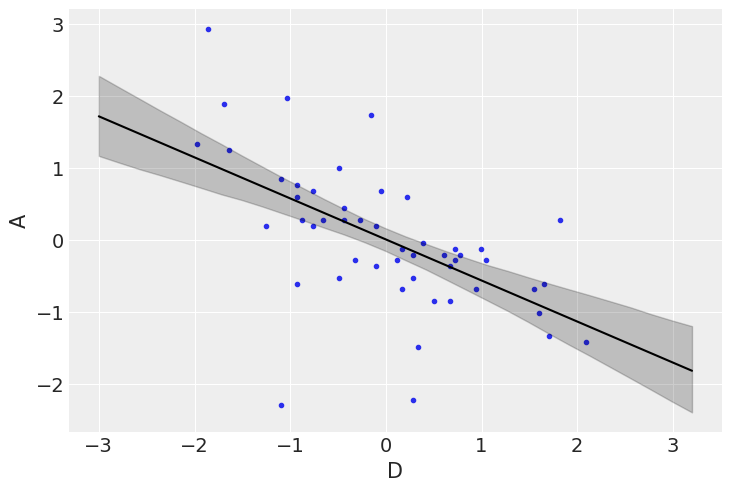

In [7]:
svi = SVI(model, m5_1, optim.Adam(1), Trace_ELBO(), A=d.A.values, D=d.D.values)
p5_1, losses = svi.run(random.PRNGKey(0), 1000)

# compute percentile interval of mean
A_seq = jnp.linspace(start=-3, stop=3.2, num=30)
post = m5_1.sample_posterior(random.PRNGKey(1), p5_1, (1000,))
post_pred = Predictive(m5_1.model, post)(random.PRNGKey(2), A=A_seq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)

# plot it all
az.plot_pair(d[["D", "A"]].to_dict(orient="list"))
plt.plot(A_seq, mu_mean, "k")
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

In [8]:
import numpy as np
d[["D", "A", "M"]].corr()

,D,A,M
D,1.000000,-0.597239,0.373731
A,-0.597239,1.000000,-0.721096
M,0.373731,-0.721096,1.000000


### Code 5.6

100%|██████████| 1000/1000 [00:01<00:00, 866.13it/s, init loss: 962.7464, avg. loss [951-1000]: 67.4809] 


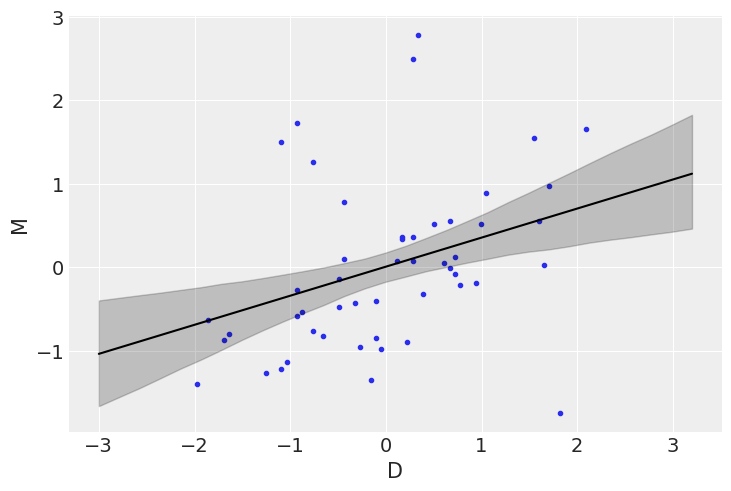

In [9]:



def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), Trace_ELBO(), M=d.M.values, D=d.D.values)
p5_2, losses = svi.run(random.PRNGKey(0), 1000)


# compute percentile interval of mean
A_seq = jnp.linspace(start=-3, stop=3.2, num=30)
post = m5_2.sample_posterior(random.PRNGKey(1), p5_2, (1000,))
post_pred = Predictive(m5_2.model, post)(random.PRNGKey(2), M=A_seq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)


# plot it all
az.plot_pair(d[["D", "M"]].to_dict(orient="list"))
plt.plot(A_seq, mu_mean, "k")
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

### Code 5.7

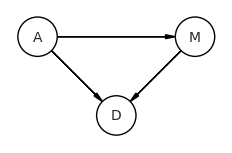

In [10]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

### Code 5.8

In [11]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)  # D and M are independent if we condition on A

('D', 'M', {'A'})


### Code 5.9

In [12]:
DMA_dag2 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

### Code 5.10

In [13]:
def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_3, optim.Adam(1), Trace_ELBO(), M=d.M.values, A=d.A.values, D=d.D.values)
p5_3, losses = svi.run(random.PRNGKey(0), 1000)
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 796.71it/s, init loss: 3201.7393, avg. loss [951-1000]: 60.7879] 



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.14   1049.96      1.00
        bA     -0.61      0.16     -0.61     -0.86     -0.36    822.38      1.00
        bM     -0.06      0.16     -0.06     -0.31      0.19    984.99      1.00
     mu[0]      0.36      0.13      0.37      0.15      0.57    921.63      1.00
     mu[1]      0.32      0.21      0.32     -0.01      0.66    900.77      1.00
     mu[2]      0.12      0.10      0.12     -0.03      0.28    995.35      1.00
     mu[3]      0.76      0.21      0.75      0.43      1.10    911.65      1.00
     mu[4]     -0.35      0.12     -0.35     -0.52     -0.14   1070.56      1.00
     mu[5]      0.12      0.15      0.12     -0.13      0.35    861.01      1.00
     mu[6]     -0.71      0.17     -0.70     -0.95     -0.42   1053.26      1.00
     mu[7]     -0.31      0.20     -0.32     -0.63      0.03    865.14      1.00
     mu[8]     -1.74      0

### Code 5.11

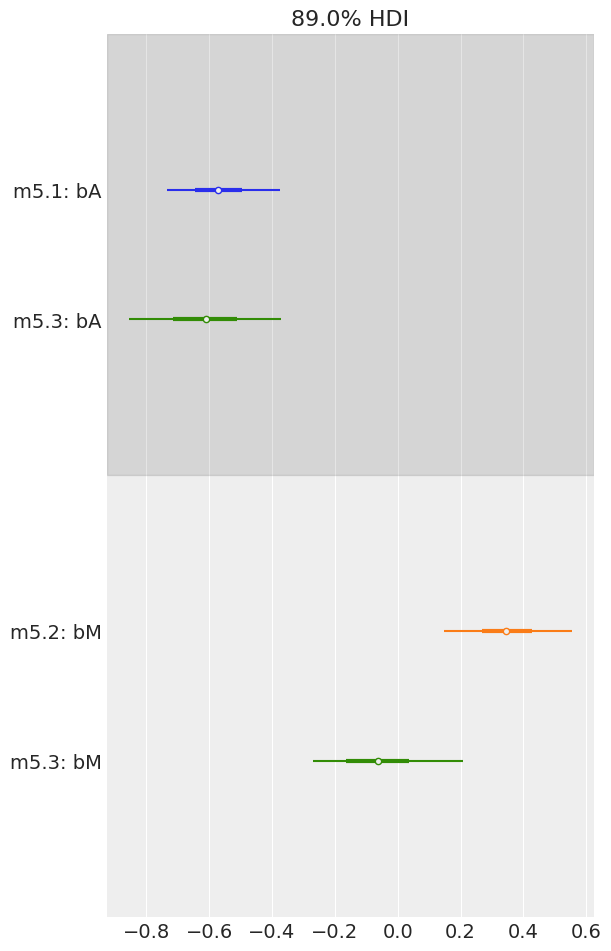

In [14]:
coeftab = {
    "m5.1": m5_1.sample_posterior(random.PRNGKey(1), p5_1, (1, 1000,)),
    "m5.2": m5_2.sample_posterior(random.PRNGKey(2), p5_2, (1, 1000,)),
    "m5.3": m5_3.sample_posterior(random.PRNGKey(3), p5_3, (1, 1000,)),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bA", "bM"],
    hdi_prob=0.89,
)
plt.show()

### Code 5.12

In [15]:
N = 50  # number of simulated States
age = dist.Normal().sample(random.PRNGKey(0), sample_shape=(N,))  # sim A
mar = dist.Normal(age).sample(random.PRNGKey(1))  # sim A -> M
div = dist.Normal(age).sample(random.PRNGKey(2))  # sim A -> D

### Code 5.13

In [16]:
def model(A, M=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bAM * A)
    numpyro.sample("M", dist.Normal(mu, sigma), obs=M)


m5_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_4, optim.Adam(0.1), Trace_ELBO(), A=d.A.values, M=d.M.values)
p5_4, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:01<00:00, 883.64it/s, init loss: 2288.6685, avg. loss [951-1000]: 53.6926] 


### Code 5.14

In [17]:
post = m5_4.sample_posterior(random.PRNGKey(1), p5_4, (1000,))
post_pred = Predictive(m5_4.model, post)(random.PRNGKey(2), A=d.A.values)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_resid = d.M.values - mu_mean

### Code 5.15

In [18]:
# call predictive without specifying new data
# so it uses original data
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (int(1e4),))
post_pred = Predictive(m5_3.model, post)(random.PRNGKey(2), M=d.M.values, A=d.A.values)
mu = post_pred["mu"]

# summarize samples across cases
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)

# simulate observations
# again no new data, so uses original data
D_sim = post_pred["D"]
D_PI = jnp.percentile(D_sim, q=(5.5, 94.5), axis=0)

In [35]:
(mu < 0.5).mean(axis=0)

DeviceArray([0.8341, 0.8066, 0.9997, 0.1099, 1.    , 0.9963, 1.    ,
             1.    , 1.    , 0.9998, 1.    , 0.9997, 0.0016, 1.    ,
             0.9973, 0.9587, 0.5416, 0.2923, 1.    , 0.9857, 1.    ,
             1.    , 0.9998, 0.9971, 0.9989, 0.9588, 0.9828, 0.8899,
             0.9999, 1.    , 0.9997, 1.    , 0.999 , 0.8493, 0.9998,
             0.0785, 0.9998, 0.9999, 1.    , 0.9999, 0.9921, 0.6614,
             0.7886, 0.0108, 1.    , 1.    , 1.    , 0.5461, 0.9998,
             0.2376], dtype=float32)

### Code 5.17

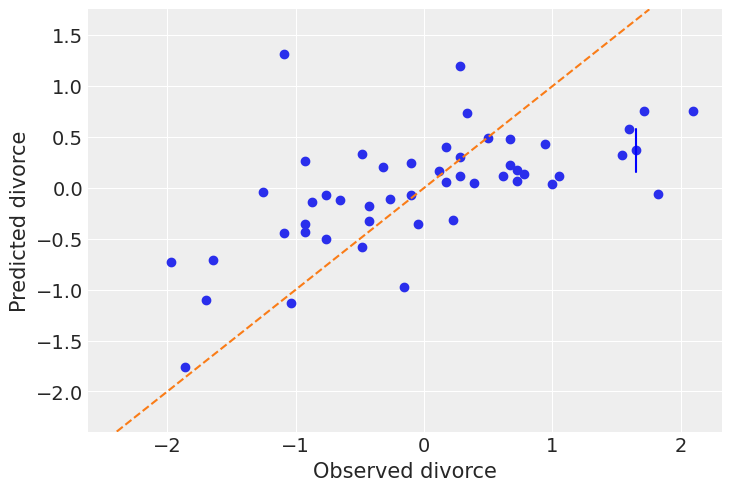

In [28]:
ax = plt.subplot(
    ylim=(float(mu_PI.min()), float(mu_PI.max())),
    xlabel="Observed divorce",
    ylabel="Predicted divorce",
)
plt.plot(d.D, mu_mean, "o")
x = jnp.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
    break
# fig = plt.gcf()

### Code 5.17

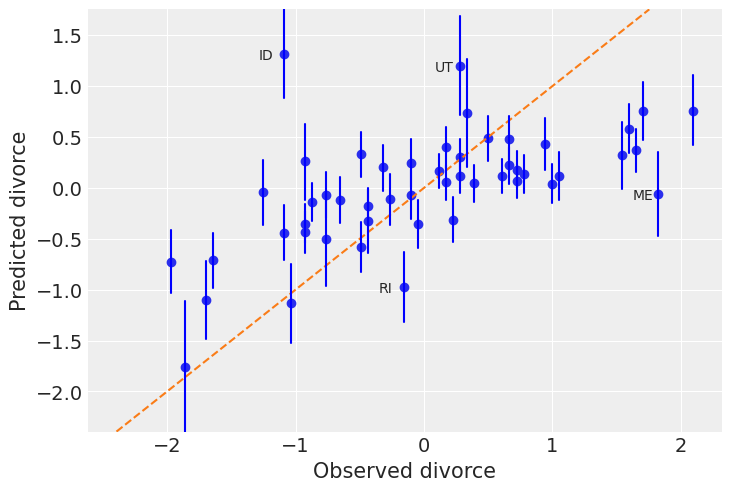

In [18]:
for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(
            d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5), textcoords="offset pixels"
        )
fig

### Code 5.18

In [19]:
N = 100  # number of cases
# x_real as Gaussian with mean 0 and stddev 1
x_real = dist.Normal().sample(random.PRNGKey(0), (N,))
# x_spur as Gaussian with mean=x_real
x_spur = dist.Normal(x_real).sample(random.PRNGKey(1))
# y as Gaussian with mean=x_real
y = dist.Normal(x_real).sample(random.PRNGKey(2))
# bind all together in data frame
d = pd.DataFrame({"y": y, "x_real": x_real, "x_spur": x_spur})

### Code 5.19

In [36]:
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())


def model(A, M=None, D=None):
    # A -> M
    aM = numpyro.sample("aM", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bAM", dist.Normal(0, 0.5))
    sigma_M = numpyro.sample("sigma_M", dist.Exponential(1))
    mu_M = aM + bAM * A
    M = numpyro.sample("M", dist.Normal(mu_M, sigma_M), obs=M)
    # A -> D <- M
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_3_A = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_3_A, optim.Adam(0.1), Trace_ELBO(), A=d.A.values, M=d.M.values, D=d.D.values
)
p5_3_A, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:01<00:00, 539.52it/s, init loss: 10480.9580, avg. loss [951-1000]: 114.4805]


### Code 5.20

In [37]:
A_seq = jnp.linspace(-2, 2, num=30)

### Code 5.21

In [38]:
# prep data
sim_dat = dict(A=A_seq)

# simulate M and then D, using A_seq
post = m5_3_A.sample_posterior(random.PRNGKey(1), p5_3_A, (1000,))
s = Predictive(m5_3_A.model, post)(random.PRNGKey(2), **sim_dat)

### Code 5.22

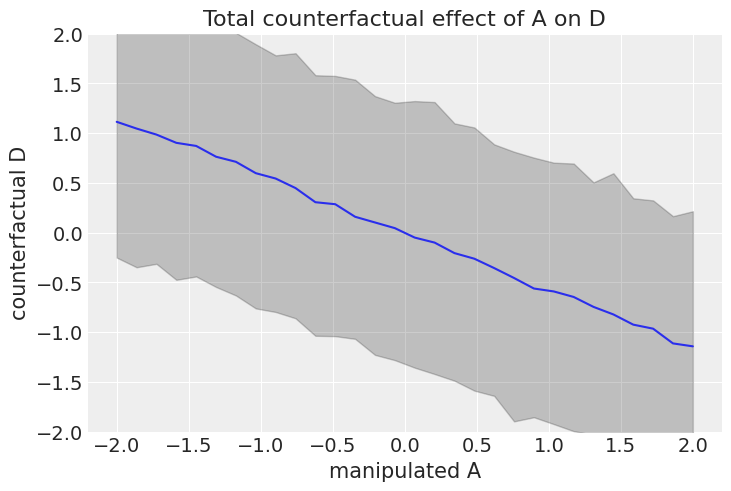

In [39]:
plt.plot(sim_dat["A"], jnp.mean(s["D"], 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(
    sim_dat["A"], *jnp.percentile(s["D"], q=(5.5, 94.5), axis=0), color="k", alpha=0.2
)
plt.title("Total counterfactual effect of A on D")
plt.show()

### Code 5.23

In [43]:
# new data frame, standardized to mean 26.1 and stddev 1.24
sim2_dat = dict(A=(jnp.array([20, 30]) - 26.1) / 1.24)
s2 = Predictive(m5_3_A.model, post, return_sites=["M", "D"])(
    random.PRNGKey(2), **sim2_dat
)
jnp.mean(s2["D"][:, 1] - s2["D"][:, 0])

DeviceArray(-4.681823, dtype=float32)

### Code 5.24

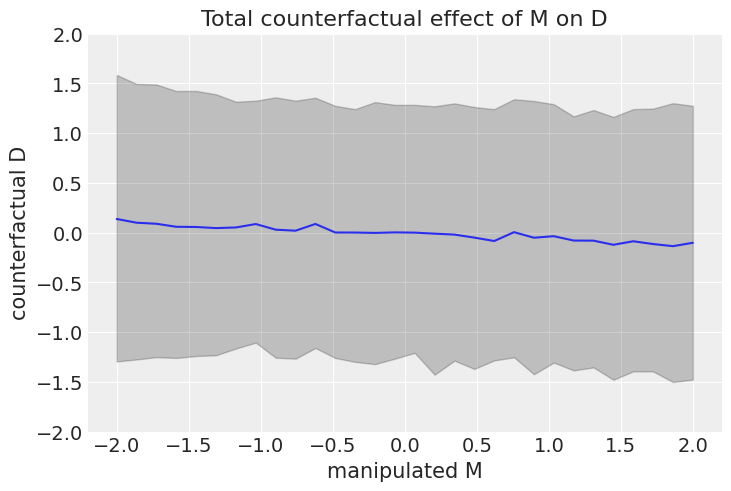

In [44]:
sim_dat = dict(M=jnp.linspace(-2, 2, num=30), A=0)
s = Predictive(m5_3_A.model, post)(random.PRNGKey(2), **sim_dat)["D"]

plt.plot(sim_dat["M"], jnp.mean(s, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated M", ylabel="counterfactual D")
plt.fill_between(
    sim_dat["M"], *jnp.percentile(s, q=(5.5, 94.5), axis=0), color="k", alpha=0.2
)
plt.title("Total counterfactual effect of M on D")
plt.show()

### Code 5.25

In [26]:
A_seq = jnp.linspace(-2, 2, num=30)

### Code 5.26

In [27]:
post = m5_3_A.sample_posterior(random.PRNGKey(1), p5_3_A, (1000,))
post = {k: v[..., None] for k, v in post.items()}
M_sim = dist.Normal(post["aM"] + post["bAM"] * A_seq).sample(random.PRNGKey(1))

### Code 5.27

In [28]:
D_sim = dist.Normal(post["a"] + post["bA"] * A_seq + post["bM"] * M_sim).sample(
    random.PRNGKey(1)
)

### Code 5.28

In [45]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### Code 5.29

In [46]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.map(math.log).pipe(lambda x: (x - x.mean()) / x.std())

### Code 5.30

In [47]:
def model(N, K):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bN = numpyro.sample("bN", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


with numpyro.validation_enabled():
    try:
        m5_5_draft = AutoLaplaceApproximation(model)
        svi = SVI(model, m5_5_draft, optim.Adam(1), Trace_ELBO(), N=d.N.values, K=d.K.values)
        p5_5_draft, losses = svi.run(random.PRNGKey(0), 1000)
    except ValueError as e:
        print(str(e))

Normal distribution got invalid loc parameter.


### Code 5.31

In [32]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### Code 5.32

In [50]:
dcc = d.iloc[d[["K", "N", "M"]].dropna(how="any", axis=0).index]

### Code 5.33

In [51]:
def model(N, K=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bN = numpyro.sample("bN", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_5_draft = AutoLaplaceApproximation(model)
svi = SVI(model, m5_5_draft, optim.Adam(0.1), Trace_ELBO(), N=dcc.N.values, K=dcc.K.values)
p5_5_draft, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1053.74it/s, init loss: 411.1621, avg. loss [951-1000]: 27.4243]


### Code 5.34

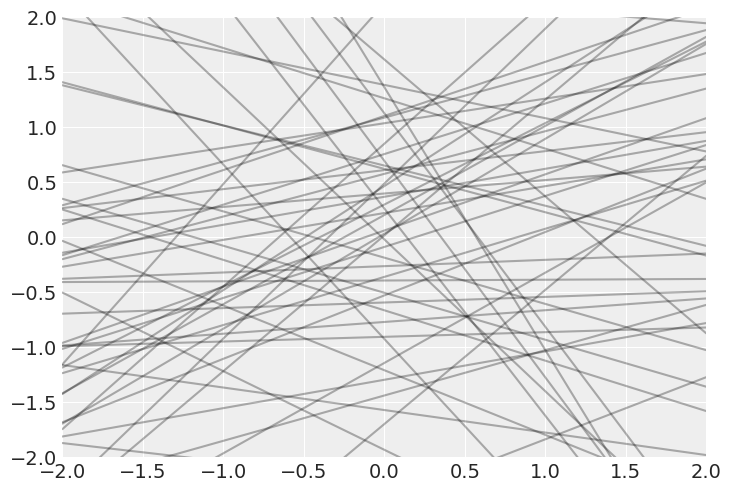

In [52]:
xseq = jnp.array([-2, 2])
prior_pred = Predictive(model, num_samples=1000)(random.PRNGKey(1), N=xseq)
mu = prior_pred["mu"]
plt.subplot(xlim=xseq, ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu[i], "k", alpha=0.3)

### Code 5.35

100%|██████████| 1000/1000 [00:00<00:00, 1031.15it/s, init loss: 414.1050, avg. loss [951-1000]: 25.1957]


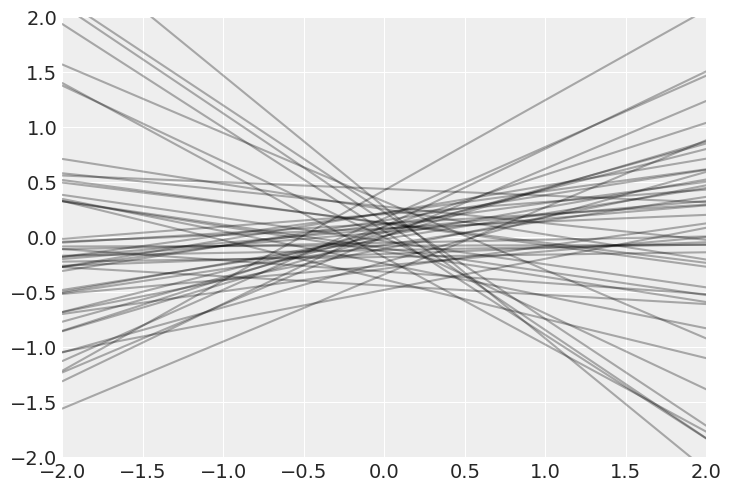

In [54]:
def model(N, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


xseq = jnp.array([-2, 2])
prior_pred = Predictive(model, num_samples=1000)(random.PRNGKey(1), N=xseq)
mu = prior_pred["mu"]
plt.subplot(xlim=xseq, ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu[i], "k", alpha=0.3)
    
m5_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_5, optim.Adam(1), Trace_ELBO(), N=dcc.N.values, K=dcc.K.values)
p5_5, losses = svi.run(random.PRNGKey(0), 1000)

### Code 5.36

In [55]:
post = m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.05      0.16      0.05     -0.21      0.29    931.50      1.00
        bN      0.13      0.23      0.13     -0.21      0.53   1111.88      1.00
     mu[0]     -0.22      0.51     -0.22     -0.99      0.60    911.65      1.00
     mu[1]     -0.02      0.20     -0.01     -0.36      0.27    906.66      1.00
     mu[2]     -0.02      0.20     -0.01     -0.36      0.27    906.66      1.00
     mu[3]      0.05      0.16      0.05     -0.21      0.29    931.28      1.00
     mu[4]      0.08      0.17      0.08     -0.18      0.36    940.50      1.00
     mu[5]     -0.14      0.38     -0.13     -0.74      0.45    889.84      1.00
     mu[6]     -0.08      0.28     -0.07     -0.52      0.36    874.50      1.00
     mu[7]     -0.11      0.33     -0.10     -0.65      0.37    884.63      1.00
     mu[8]      0.10      0.18      0.10     -0.18      0.41    964.72      1.00
     mu[9]      0.11      0

### Code 5.37

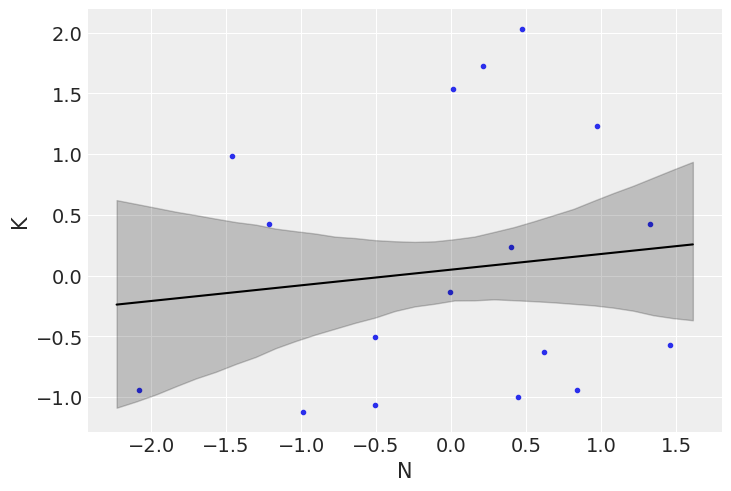

In [56]:
xseq = jnp.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1000,))
post_pred = Predictive(m5_5.model, post)(random.PRNGKey(2), N=xseq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)
az.plot_pair(dcc[["N", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

### Code 5.38

In [57]:
def model(M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_6, optim.Adam(1), Trace_ELBO(), M=dcc.M.values, K=dcc.K.values)
p5_6, losses = svi.run(random.PRNGKey(0), 1000)
post = m5_6.sample_posterior(random.PRNGKey(1), p5_6, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:00<00:00, 1021.19it/s, init loss: 756.0300, avg. loss [951-1000]: 24.4211]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.16      0.06     -0.20      0.29    931.50      1.00
        bM     -0.28      0.20     -0.28     -0.61      0.03   1088.44      1.00
     mu[0]      0.18      0.18      0.19     -0.11      0.47    944.38      1.00
     mu[1]      0.02      0.16      0.02     -0.24      0.26    932.90      1.00
     mu[2]      0.02      0.16      0.02     -0.24      0.26    933.51      1.00
     mu[3]      0.14      0.17      0.15     -0.11      0.42    958.01      1.00
     mu[4]      0.36      0.27      0.36     -0.07      0.78    872.95      1.00
     mu[5]      0.65      0.45      0.65     -0.03      1.39    898.89      1.00
     mu[6]      0.42      0.31      0.43     -0.07      0.89    878.58      1.00
     mu[7]      0.49      0.35      0.50     -0.09      1.00    885.51      1.00
     mu[8]      0.22      0.20      0.23     -0.12      0.51    906.05      1.00
     mu[9]      0.10      0

### Code 5.39

In [58]:
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_7 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_7, optim.Adam(1), Trace_ELBO(), N=dcc.N.values, M=dcc.M.values, K=dcc.K.values
)
p5_7, losses = svi.run(random.PRNGKey(0), 1000)
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 986.73it/s, init loss: 136.3944, avg. loss [951-1000]: 22.0707]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.13      0.06     -0.15      0.26   1049.96      1.00
        bM     -0.68      0.23     -0.68     -1.06     -0.32    837.54      1.00
        bN      0.65      0.25      0.66      0.25      1.06    885.39      1.00
     mu[0]     -0.99      0.47     -1.00     -1.72     -0.22    953.05      1.00
     mu[1]     -0.36      0.20     -0.35     -0.64     -0.03   1076.34      1.00
     mu[2]     -0.37      0.20     -0.36     -0.65     -0.03   1068.21      1.00
     mu[3]      0.28      0.16      0.28      0.03      0.52    967.73      1.00
     mu[4]      0.94      0.33      0.94      0.43      1.44    876.35      1.00
     mu[5]      0.53      0.39      0.53     -0.10      1.11   1015.67      1.00
     mu[6]      0.30      0.26      0.30     -0.10      0.73   1041.23      1.00
     mu[7]      0.30      0.30      0.30     -0.16      0.76   1039.12      1.00
     mu[8]      0.73      0

### Code 5.40

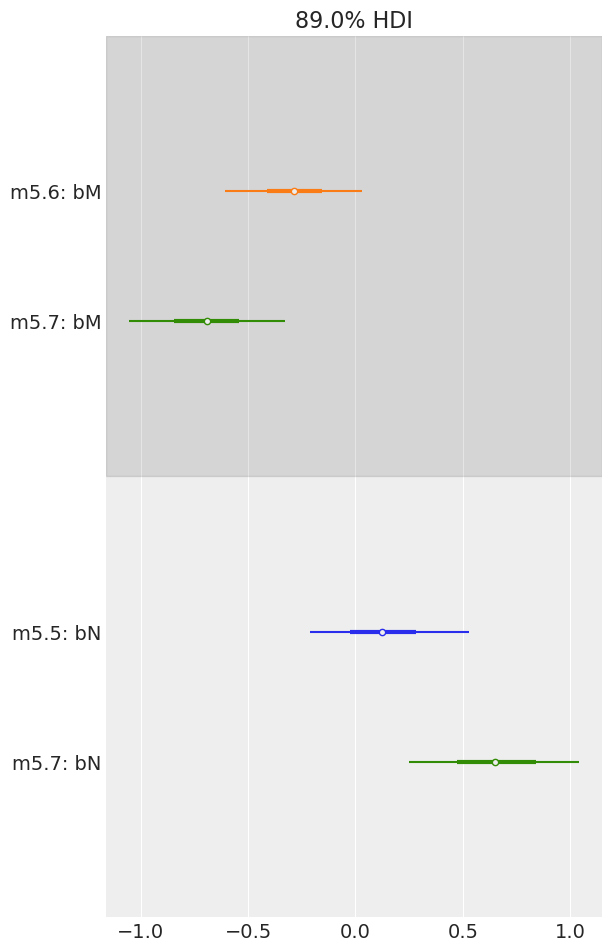

In [41]:
coeftab = {
    "m5.5": m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1, 1000,)),
    "m5.6": m5_6.sample_posterior(random.PRNGKey(2), p5_6, (1, 1000,)),
    "m5.7": m5_7.sample_posterior(random.PRNGKey(3), p5_7, (1, 1000,)),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bM", "bN"],
    hdi_prob=0.89,
)
plt.show()

### Code 5.41

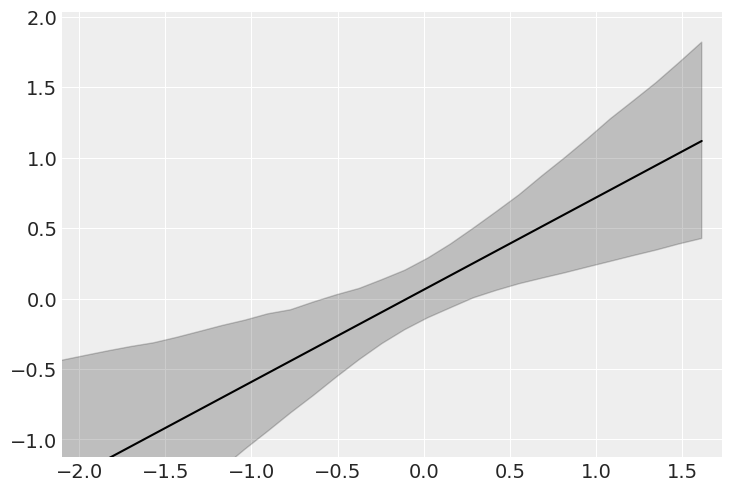

In [59]:
xseq = jnp.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
post_pred = Predictive(m5_7.model, post)(random.PRNGKey(2), M=0, N=xseq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)
plt.subplot(xlim=(dcc.M.min(), dcc.M.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

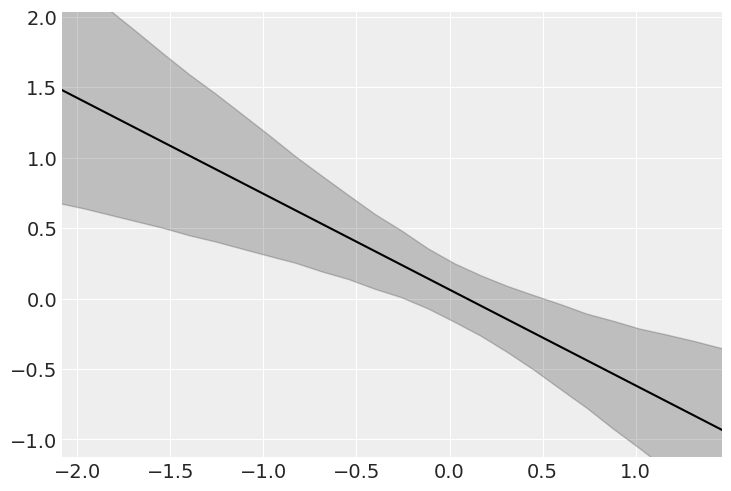

In [60]:
xseq = jnp.linspace(start=dcc.M.min() - 0.15, stop=dcc.M.max() + 0.15, num=30)
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
post_pred = Predictive(m5_7.model, post)(random.PRNGKey(2), N=0, M=xseq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)
plt.subplot(xlim=(dcc.N.min(), dcc.N.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

### Code 5.42

In [43]:
# M -> K <- N
# M -> N
n = 100
M = dist.Normal().sample(random.PRNGKey(0), (n,))
N = dist.Normal(M).sample(random.PRNGKey(1))
K = dist.Normal(N - M).sample(random.PRNGKey(2))
d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

### Code 5.43

In [44]:
# M -> K <- N
# N -> M
n = 100
N = dist.Normal().sample(random.PRNGKey(0), (n,))
M = dist.Normal(N).sample(random.PRNGKey(1))
K = dist.Normal(N - M).sample(random.PRNGKey(2))
d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

# M -> K <- N
# M <- U -> N
n = 100
N = dist.Normal().sample(random.PRNGKey(3), (n,))
M = dist.Normal(M).sample(random.PRNGKey(4))
K = dist.Normal(N - M).sample(random.PRNGKey(5))
d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})

### Code 5.44

In [61]:
dag5_7 = CausalGraphicalModel(
    nodes=["M", "K", "N"], edges=[("M", "K"), ("N", "K"), ("M", "N")]
)
coordinates = {"M": (0, 0.5), "K": (1, 1), "N": (2, 0.5)}
nodes = list(dag5_7.dag.nodes.keys())
edges = list(dag5_7.dag.edges.keys())
MElist = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            try:
                new_dag = CausalGraphicalModel(
                    nodes=nodes,
                    edges=[
                        edges[0] if i == 0 else edges[0][::-1],
                        edges[1] if j == 0 else edges[1][::-1],
                        edges[2] if k == 0 else edges[2][::-1],
                    ],
                )
                MElist.append(new_dag)
            except:
                pass

### Code 5.45

In [46]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 5.46

In [47]:
mu_female = dist.Normal(178, 20).sample(random.PRNGKey(0), (int(1e4),))
diff = dist.Normal(0, 10).sample(random.PRNGKey(1), (int(1e4),))
mu_male = dist.Normal(178, 20).sample(random.PRNGKey(2), (int(1e4),)) + diff
print_summary({"mu_female": mu_female, "mu_male": mu_male}, 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
  mu_female    178.21     20.22    178.24    147.19    211.84   9943.61      1.00
    mu_male    178.10     22.36    178.51    142.35    213.41  10190.57      1.00



### Code 5.47

In [48]:
d["sex"] = jnp.where(d.male.values == 1, 1, 0)
d.sex

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int32

### Code 5.48

In [49]:
def model(sex, height):
    a = numpyro.sample("a", dist.Normal(178, 20).expand([len(set(sex))]))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a[sex]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m5_8 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_8, optim.Adam(1), Trace_ELBO(), sex=d.sex.values, height=d.height.values)
p5_8, losses = svi.run(random.PRNGKey(0), 2000)
post = m5_8.sample_posterior(random.PRNGKey(1), p5_8, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 2000/2000 [00:01<00:00, 1815.39it/s, init loss: 5607.9023, avg. loss [1901-2000]: 2558.3149]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



### Code 5.49

In [50]:
post = m5_8.sample_posterior(random.PRNGKey(1), p5_8, (1000,))
post["diff_fm"] = post["a"][:, 0] - post["a"][:, 1]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
   diff_fm     -7.54      2.38     -7.47    -11.77     -4.32    876.56      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



### Code 5.50

In [51]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

### Code 5.51

In [52]:
d["clade_id"] = d.clade.astype("category").cat.codes

### Code 5.52

100%|██████████| 1000/1000 [00:00<00:00, 1407.72it/s, init loss: 94.6847, avg. loss [951-1000]: 35.5646]


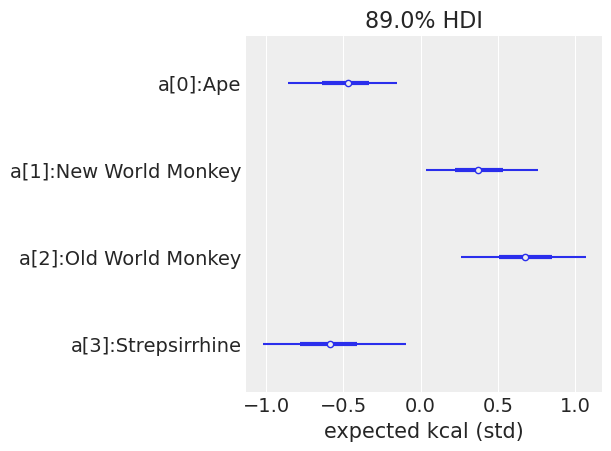

In [53]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())


def model(clade_id, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5).expand([len(set(clade_id))]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=K)


m5_9 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_9, optim.Adam(1), Trace_ELBO(), clade_id=d.clade_id.values, K=d.K.values)
p5_9, losses = svi.run(random.PRNGKey(0), 1000)
post = m5_9.sample_posterior(random.PRNGKey(1), p5_9, (1000,))
labels = ["a[" + str(i) + "]:" + s for i, s in enumerate(sorted(d.clade.unique()))]
az.plot_forest({"a": post["a"][None, ...]}, hdi_prob=0.89)
plt.gca().set(yticklabels=labels[::-1], xlabel="expected kcal (std)")
plt.show()

### Code 5.53

In [54]:
key = random.PRNGKey(63)
d["house"] = random.choice(key, jnp.repeat(jnp.arange(4), 8), d.shape[:1], False)

### Code 5.54

In [55]:
def model(clade_id, house, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5).expand([len(set(clade_id))]))
    h = numpyro.sample("h", dist.Normal(0, 0.5).expand([len(set(house))]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id] + h[house]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=K)


m5_10 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_10,
    optim.Adam(1),
    Trace_ELBO(),
    clade_id=d.clade_id.values,
    house=d.house.values,
    K=d.K.values,
)
p5_10, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1231.03it/s, init loss: 491.4240, avg. loss [951-1000]: 35.8243]
